# Analyses of Arabidopsis drought gene expression data
This notebook contains code on analyzing drought RNAseq data in Arabidopsis from VanBuren et al. 2024.  This includes filtering and describing the input data, combat  adjustment, dimesionality reduction, and plotting expression of individual drought marker genes. 

In [1]:
# Import packages
import pandas as pd
import numpy as np
import re
import json
import csv
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.cluster import hierarchy
plt.rcParams['pdf.fonttype'] = 42

## Plotting drought experimental factors

We fill first plot the metadata from the curated arabidopsis data using the tab delimited file 'meta_data.txt'

In [2]:
# Load metadata from published experiments. 
metadf = pd.read_csv('Arabidopsis_meta_data.txt', delimiter='\t')
metadf.head()

Species          Journal  Year  Number of citations  \
0  Arabidopsis_thaliana     BMC Genomics  2019                   15   
1  Arabidopsis_thaliana   BMC Plant Biol  2013                  237   
2  Arabidopsis_thaliana  Front Plant Sci  2023                    0   
3  Arabidopsis_thaliana  Front Plant Sci  2016                   52   
4  Arabidopsis_thaliana  Front Plant Sci  2015                  183   

  Transgenic? (Y/N) Tissue(s)  Developmental stage     Environment Media  \
0                 Y      leaf                 12.0  Growth_chamber  Soil   
1                 N      leaf                 30.0  Growth_chamber  Soil   
2                 Y      leaf                 21.0  Growth_chamber  Soil   
3                 Y      leaf                 28.0  Growth_chamber  Soil   
4                 N      leaf                 28.0  Growth_chamber  Soil   

   Stress duration   Mechanism_drying Physiology datasets  \
0             21.0     Natural_drying              RWC,EL   
1              NaN         Air_drying                 NaN   
2             22.0  Controlled_drying            SMC,FvFm   
3             14.0     Natural_drying                 NaN   
4              NaN  Controlled_drying                 RWC   

   Number of timepoints  Number of replicates  
0                   NaN                   3.0  
1                   NaN                   NaN  
2                   NaN                   NaN  
3                   NaN                   3.0  
4                   NaN                   3.0

C:\Users\15173\AppData\Local\Temp\ipykernel_24496\3778209752.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=45, ha='right')
C:\Users\15173\AppData\Local\Temp\ipykernel_24496\3778209752.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=45, ha='right')


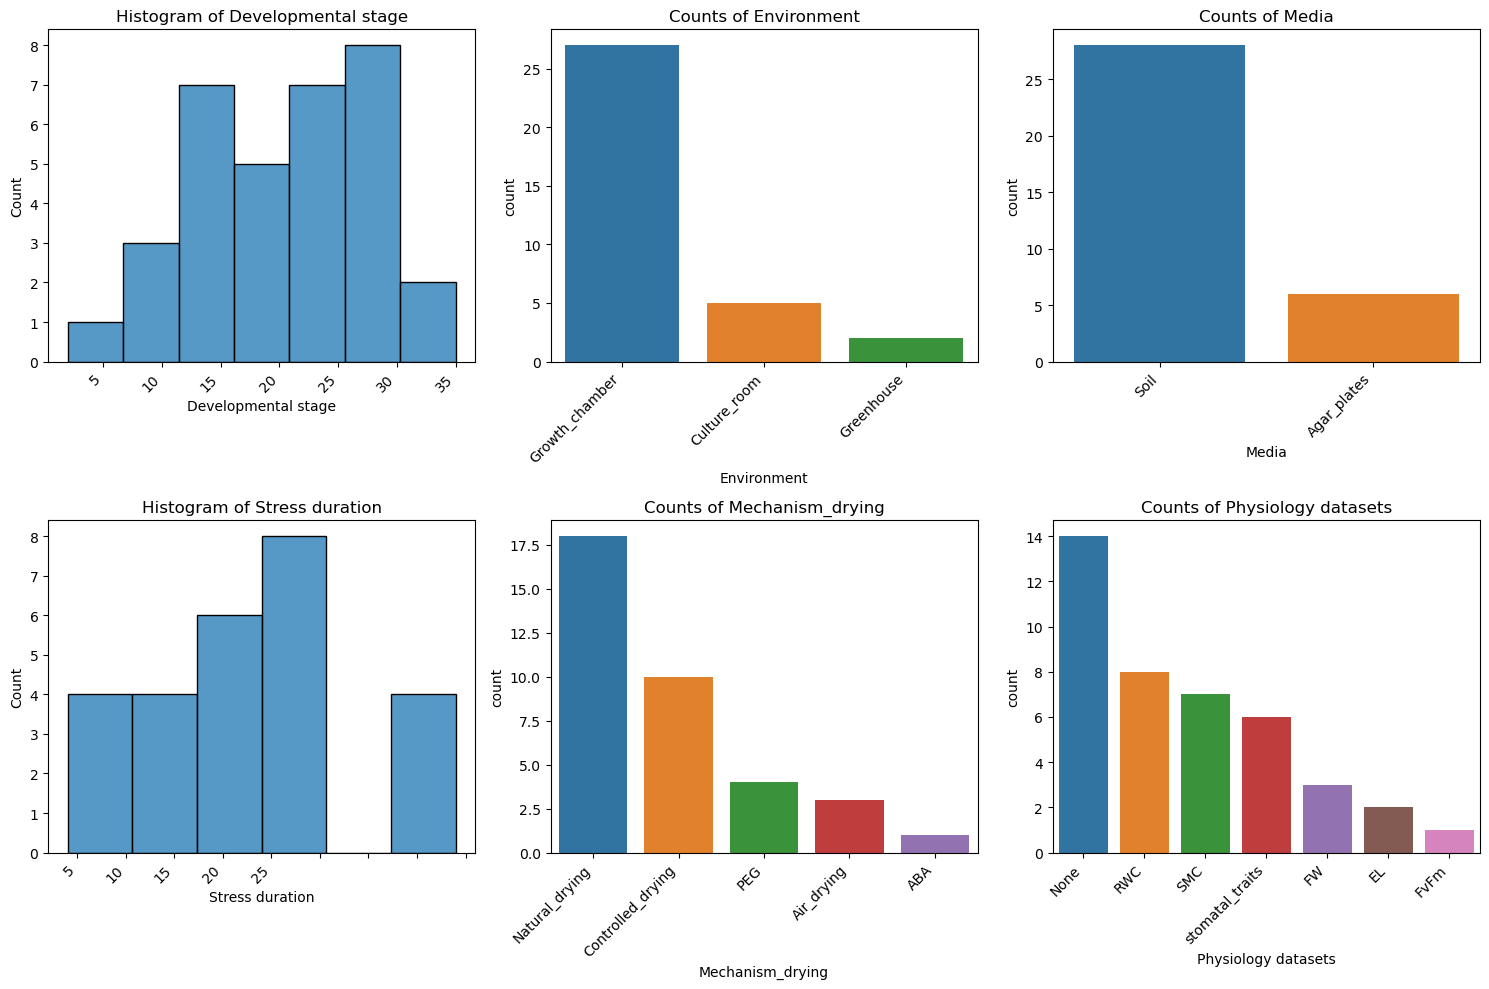

In [21]:
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 3, figsize=(15,10))

# Columns you want to plot
cols = ['Developmental stage', 'Environment', 'Media', 'Stress duration', 'Mechanism_drying', 'Physiology datasets']

for i, col in enumerate(cols):
    if col in ['Developmental stage', 'Stress duration']:
        # For specified columns, plot as histogram
        sns.histplot(metadf[col], ax=axes[i//3, i%3], bins='auto', kde=False)
        axes[i//3, i%3].set_title(f"Histogram of {col}")
        axes[i//3, i%3].set_ylabel('Count')
    else:
        if col == 'Physiology datasets':
            # Split by commas and explode
            exploded_data = metadf[col].str.split(',').explode()
            category_counts = exploded_data.value_counts().reset_index()
            category_counts.columns = [col, 'count']
        else:
            # Count the occurrences of each category in the column
            category_counts = metadf[col].value_counts().reset_index()
            category_counts.columns = [col, 'count']
        # For other columns, plot as bar plot
        sns.barplot(data=category_counts, x=col, y='count', ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(f"Counts of {col}")
    
    # Rotate x-axis labels for all subplots
    axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("output_figure.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Plotting read alignment statistics
Let's plot the mapping rates of each SRA accession. Mapping percentages were concatenated from individual Salmon outputs. 

In [25]:
# Import expression dataframe
df = pd.read_csv('read_mapping.txt', delimiter='\t')
df.head()

Species          SRA  Percent
0  Arabidopsis   ERR1588879    87.06
1  Arabidopsis   ERR1588790    85.90
2  Arabidopsis   ERR1588886    85.90
3  Arabidopsis  SRR15294178    84.91
4  Arabidopsis  SRR15294159    84.67

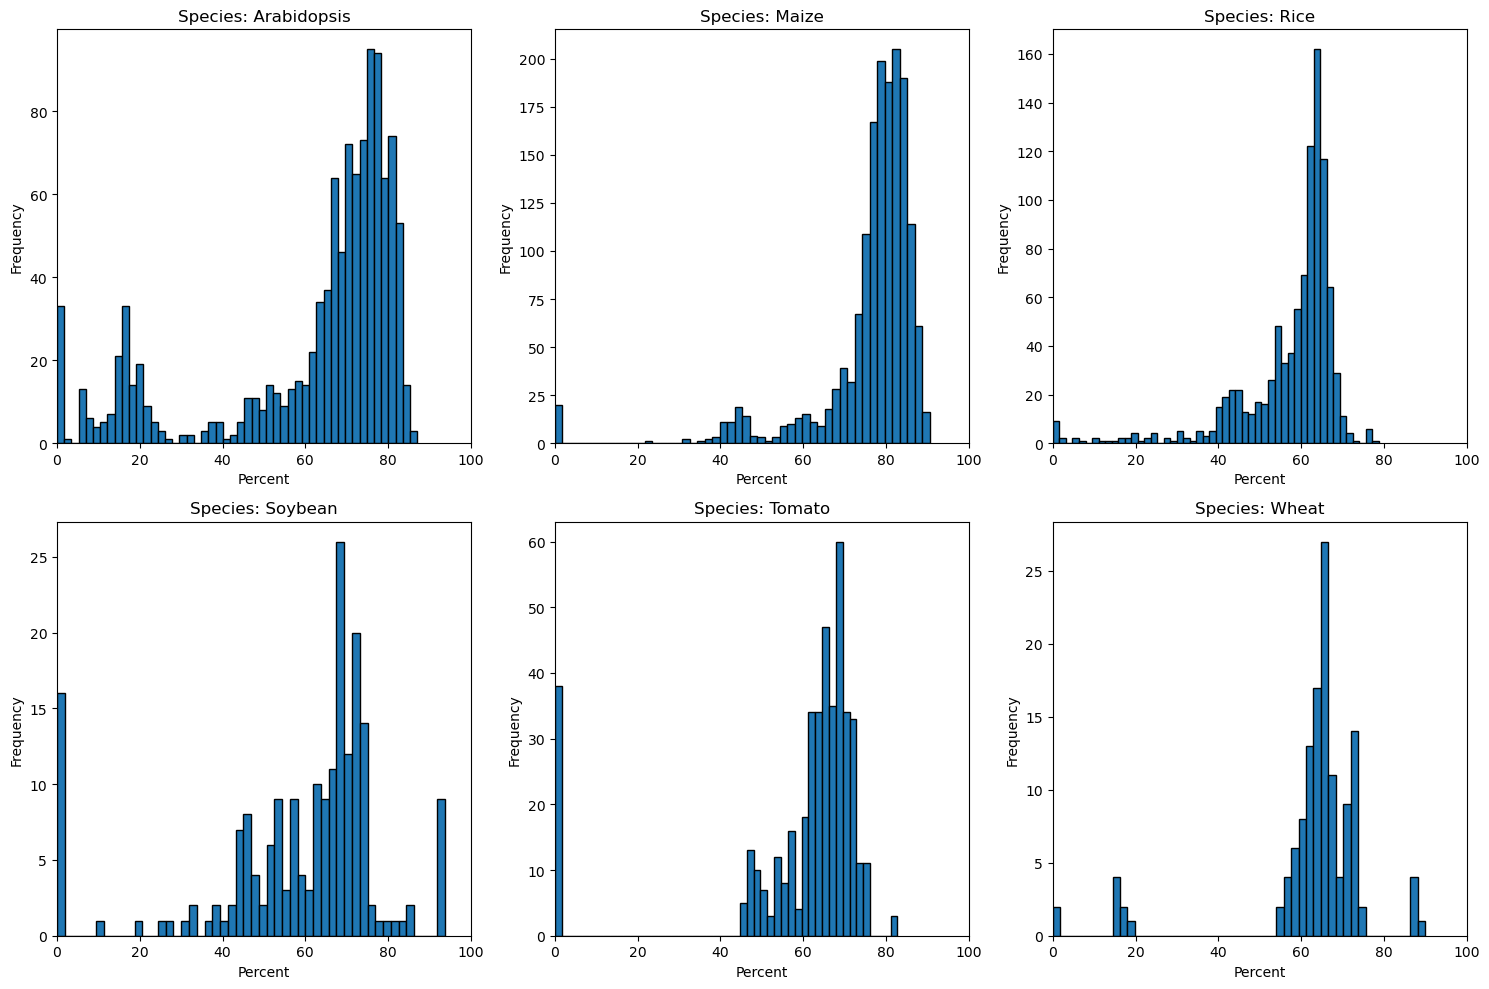

<Figure size 640x480 with 0 Axes>

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# If you're reading from a file, use:
# df = pd.read_csv('filename.csv')

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Iterate through unique species and plot histograms
for i, species in enumerate(df['Species'].unique()):
    ax = axes[i]
    subset = df[df['Species'] == species]['Percent']
    ax.hist(subset, bins=50, edgecolor='black') # You can customize the bins and other properties
    ax.set_title(f'Species: {species}')
    ax.set_xlabel('Percent')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 100)
# Adjust layout
plt.tight_layout()
plt.show()
plt.savefig('read_alignment_histogram.pdf', format='pdf')

## Importing expression data

The Arabidopsis drought RNAseq data contains 1,301 samples. Raw reads were downloaded from the SRA, trimmed using fastp, and pseudoaligned to the Arabidopsis TAIR11 gene models as described in the methods of VanBuren et al. 2024. Briefly, genes and SRA samples with little to no expression were filtered out, and log2+1 transformed for all downstream analyses. 

In [3]:
# Import the Arabidopsis gene expression dataframe
expr_df = pd.read_csv('Arabidopsis_TPM_8-14-23.tsv', delimiter='\t')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()

SRR13134698  SRR13134697  SRR13134696  SRR13134695  SRR13134694  \
GeneID                                                                       
AT1G01010     6.194397     6.755819     6.240131    11.211688    14.528159   
AT1G01020     6.313488     5.980893     6.799152    15.006115    13.306829   
AT1G01030     2.495984     2.453966     2.491543     3.122946     5.199754   
AT1G01040    15.888175    14.959274    13.426500    15.636013    15.652931   
AT1G01050    86.296448    76.257584    84.999951    92.253649    71.635072   

           SRR13134693  SRR13134692  SRR13134691  SRR13134690  SRR13134689  \
GeneID                                                                       
AT1G01010     3.364697    11.349768     6.977708     4.879251     3.677041   
AT1G01020     6.192358    15.266935     8.754127     4.351148     3.461339   
AT1G01030     3.316352     4.401286     2.549273     3.688480     3.267363   
AT1G01040     9.677851    16.475769    16.655656    10.282821     8.272203   
AT1G01050    75.300099    82.279578    83.941553    76.164501    85.124187   

           ...  SRR7217357  SRR7217358  SRR7217361  SRR7217362  SRR7217364  \
GeneID     ...                                                               
AT1G01010  ...    1.314620    0.980246    1.144093    0.224945    0.766847   
AT1G01020  ...    6.628328    8.727316    8.726632    2.895204    3.319839   
AT1G01030  ...    0.197505    0.104904    0.393433    0.160918    0.142264   
AT1G01040  ...    1.863715    1.312444    1.780143    0.860325    0.857214   
AT1G01050  ...   14.894059   12.494360   15.281672   12.017407   10.660425   

           SRR7217365  SRR7217367  SRR7217372  SRR7217373  SRR7217375  
GeneID                                                                 
AT1G01010    0.993218    0.688191    0.364360    0.618026    0.620158  
AT1G01020    5.118361    2.984822    1.740033    2.616836    2.756868  
AT1G01030    0.115867    0.124270    0.050160    0.034014    0.161809  
AT1G01040    1.262846    1.640237    1.041538    1.315620    1.218821  
AT1G01050   13.260913   18.150083    8.724780   11.025545    8.093256  

[5 rows x 1301 columns]

In [4]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 10, :]
expr_df.shape

## Filter out lowly expressed genes
mask_low_vals = (expr_df > 1).sum(axis=1) > 10
expr_df = expr_df.loc[mask_low_vals, :]

expr_df.shape

(24591, 1301)

In [5]:
# Remove any SRA files with 0 mapped reads across all Arabidopsis genes
filtered_df = expr_df.loc[:, (expr_df != 0).any(axis=0)]
filtered_df.shape

(24591, 1290)

In [6]:
# Create a function for log transforming expression data
def log_transform(df):
    log_df = df.copy() 
    
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] += 1
    for c in [c for c in log_df.columns if np.issubdtype(log_df[c].dtype , np.number)]:
        log_df[c] = np.log(log_df[c])
    return log_df

log_expr_df = log_transform(expr_df)
log_expr_df.head()

SRR13134698  SRR13134697  SRR13134696  SRR13134695  SRR13134694  \
GeneID                                                                       
AT1G01010     1.973303     2.048443     1.979639     2.502394     2.742655   
AT1G01020     1.989720     1.943177     2.054015     2.772971     2.660737   
AT1G01030     1.251615     1.239523     1.250344     1.416568     1.824510   
AT1G01040     2.826614     2.770040     2.669067     2.811570     2.812586   
AT1G01050     4.469310     4.347145     4.454347     4.535323     4.285448   

           SRR13134693  SRR13134692  SRR13134691  SRR13134690  SRR13134689  \
GeneID                                                                       
AT1G01010     1.473549     2.513637     2.076651     1.771429     1.542666   
AT1G01020     1.973019     2.789135     2.277690     1.677311     1.495449   
AT1G01030     1.462411     1.686637     1.266743     1.545108     1.450996   
AT1G01040     2.368172     2.860815     2.871056     2.423281     2.227021   
AT1G01050     4.334674     4.422203     4.441963     4.345940     4.455790   

           ...  SRR7217357  SRR7217358  SRR7217361  SRR7217362  SRR7217364  \
GeneID     ...                                                               
AT1G01010  ...    0.839246    0.683221    0.762717    0.202896    0.569197   
AT1G01020  ...    2.031869    2.274938    2.274868    1.359746    1.463218   
AT1G01030  ...    0.180240    0.099758    0.331770    0.149211    0.133012   
AT1G01040  ...    1.052120    0.838305    1.022502    0.620751    0.619078   
AT1G01050  ...    2.765945    2.602272    2.790040    2.566287    2.456201   

           SRR7217365  SRR7217367  SRR7217372  SRR7217373  SRR7217375  
GeneID                                                                 
AT1G01010    0.689750    0.523658    0.310685    0.481207    0.482524  
AT1G01020    1.811294    1.382493    1.007970    1.285600    1.323586  
AT1G01030    0.109632    0.117134    0.048943    0.033448    0.149978  
AT1G01040    0.816623    0.970869    0.713703    0.839677    0.796976  
AT1G01050    2.657522    2.952307    2.274677    2.487033    2.207533  

[5 rows x 1301 columns]

In [7]:
# Transpose the data so each row corresponds to an SRA numbers
expr_df_trans = expr_df.transpose()
log_expr_df_trans = log_expr_df.transpose()

log_expr_df_trans.head()


GeneID       AT1G01010  AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  \
SRR13134698   1.973303   1.989720   1.251615   2.826614   4.469310   2.534552   
SRR13134697   2.048443   1.943177   1.239523   2.770040   4.347145   2.626651   
SRR13134696   1.979639   2.054015   1.250344   2.669067   4.454347   2.154850   
SRR13134695   2.502394   2.772971   1.416568   2.811570   4.535323   1.971287   
SRR13134694   2.742655   2.660737   1.824510   2.812586   4.285448   1.874525   

GeneID       AT1G01070  AT1G01080  AT1G01090  AT1G01100  ...  ATMG01275  \
SRR13134698   2.442592   3.528407   4.589218   5.798741  ...   0.615206   
SRR13134697   1.969062   3.505378   4.534910   6.013694  ...   0.999145   
SRR13134696   1.922860   3.489413   4.439072   6.289056  ...   0.000000   
SRR13134695   2.480335   3.167088   4.341457   6.193354  ...   0.000000   
SRR13134694   1.947453   3.449664   4.343682   6.087006  ...   0.000000   

GeneID       ATMG01280  ATMG01290  ATMG01320  ATMG01330  ATMG01350  ATMG01360  \
SRR13134698   0.362489   0.000000   1.384015   1.735014   0.201441   1.335908   
SRR13134697   0.268239   0.000000   0.000000   0.472994   0.000000   0.935013   
SRR13134696   0.000000   0.387136   0.476009   0.000000   0.000000   0.696638   
SRR13134695   0.236895   0.000000   0.860832   0.233221   0.000000   0.855508   
SRR13134694   0.429225   0.000000   0.501084   1.666563   0.000000   0.813918   

GeneID       ATMG01370  ATMG01400  ATMG01410  
SRR13134698   0.456568        0.0        0.0  
SRR13134697   1.028488        0.0        0.0  
SRR13134696   1.137097        0.0        0.0  
SRR13134695   0.310835        0.0        0.0  
SRR13134694   0.290220        0.0        0.0  

[5 rows x 24591 columns]

## Dimensionality reduction of the Arabidopsis drought gene expression data

### PCA

In [8]:
# Create a function to run the principal component analysis
from sklearn.decomposition import PCA

def apply_pca(data, num_c=2, return_pca=False):
    """
    data : data to fit PCA on
    num_c : Number of principal components for PCA
    return_pca : should the function also return the PCA object (for looking at things like explained variance ratio) 
    """
    pca = PCA(n_components=num_c)
    real_PCs = pca.fit_transform(data)
    real_PCs_df = pd.DataFrame(data=real_PCs, columns=[f'PC{i}' for i in range(1, num_c+1)])
    if return_pca:
        return real_PCs_df, pca
    else:
        return real_PCs_df

In [9]:
# Return the % of variation that PC1 and PC2 explain in our data
real_PCs_df = apply_pca(log_expr_df_trans)

log_real_PCs_df, log_pca = apply_pca(log_expr_df_trans, return_pca=True)
print(log_pca.explained_variance_ratio_)

[0.39082275 0.16305858]


In [10]:
# Import data labels for RNAseq data and create an index
raw_labels = pd.read_csv("Arabidopsis_drought_labels.txt")
raw_labels = raw_labels.set_index('Run')
raw_labels.head()

Instrument LibraryLayout  ReleaseDate  AvgSpotLen  \
Run                                                                     
SRR649737  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649738  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649739  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649740  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649741  Illumina_HiSeq_2000        SINGLE         2015       100.0   

            BioProject  BioProject_num    Ecotype       Treatment       Tissue  
Run                                                                             
SRR649737  PRJNA186735             1.0  not_Col-0         Control  whole_plant  
SRR649738  PRJNA186735             1.0  not_Col-0         Control  whole_plant  
SRR649739  PRJNA186735             1.0  not_Col-0  Drought_stress  whole_plant  
SRR649740  PRJNA186735             1.0  not_Col-0  Drought_stress  whole_plant  
SRR649741  PRJNA186735             1.0  not_Col-0         Control  whole_plant

In [11]:
raw_labels.columns

Index(['Instrument', 'LibraryLayout', 'ReleaseDate', 'AvgSpotLen',
       'BioProject', 'BioProject_num', 'Ecotype', 'Treatment', 'Tissue'],
      dtype='object')

In [12]:
# Relabel expression dataframe
labeling_rows = []

columns =[('Instrument', 'Instrument'), 
           ('LibraryLayout', 'LibraryLayout'), 
           ('ReleaseDate', 'ReleaseDate'), ('AvgSpotLen', 'AvgSpotLen'),
           ('BioProject', 'BioProject'), ('BioProject_num', 'BioProject_num'), ('Ecotype', 'Ecotype'),
           ('Treatment', 'Treatment'), ('Tissue', 'Tissue')]
for srr in list(expr_df_trans.index):
    entry = raw_labels.loc[srr]
    row = {'Run' : srr}
    for old_colname, new_colname in columns:
        row[new_colname] = entry[old_colname]
    labeling_rows.append(row)

label_df = pd.DataFrame(labeling_rows)
label_df

Run             Instrument LibraryLayout  ReleaseDate  \
0     SRR13134698  Illumina_NovaSeq_6000        PAIRED         2021   
1     SRR13134697  Illumina_NovaSeq_6000        PAIRED         2021   
2     SRR13134696  Illumina_NovaSeq_6000        PAIRED         2021   
3     SRR13134695  Illumina_NovaSeq_6000        PAIRED         2021   
4     SRR13134694  Illumina_NovaSeq_6000        PAIRED         2021   
...           ...                    ...           ...          ...   
1296   SRR7217365    Illumina HiSeq 1500        SINGLE         2018   
1297   SRR7217367    Illumina HiSeq 1500        SINGLE         2018   
1298   SRR7217372    Illumina HiSeq 1500        SINGLE         2018   
1299   SRR7217373    Illumina HiSeq 1500        SINGLE         2018   
1300   SRR7217375    Illumina HiSeq 1500        SINGLE         2018   

      AvgSpotLen   BioProject  BioProject_num    Ecotype       Treatment  \
0          300.0  PRJNA680761            70.0  not_Col-0  Drought_stress   
1          300.0  PRJNA680761            70.0  not_Col-0  Drought_stress   
2          300.0  PRJNA680761            70.0  not_Col-0  Drought_stress   
3          300.0  PRJNA680761            70.0  not_Col-0         Control   
4          300.0  PRJNA680761            70.0  not_Col-0         Control   
...          ...          ...             ...        ...             ...   
1296         NaN  PRJNA304664           110.0      Col-0  Drought_stress   
1297         NaN  PRJNA304664           110.0      Col-0  Drought_stress   
1298         NaN  PRJNA304664           110.0      Col-0  Drought_stress   
1299         NaN  PRJNA304664           110.0      Col-0  Drought_stress   
1300         NaN  PRJNA304664           110.0      Col-0  Drought_stress   

           Tissue  
0     whole_plant  
1     whole_plant  
2     whole_plant  
3     whole_plant  
4     whole_plant  
...           ...  
1296         leaf  
1297         leaf  
1298         leaf  
1299         leaf  
1300         leaf  

[1301 rows x 10 columns]

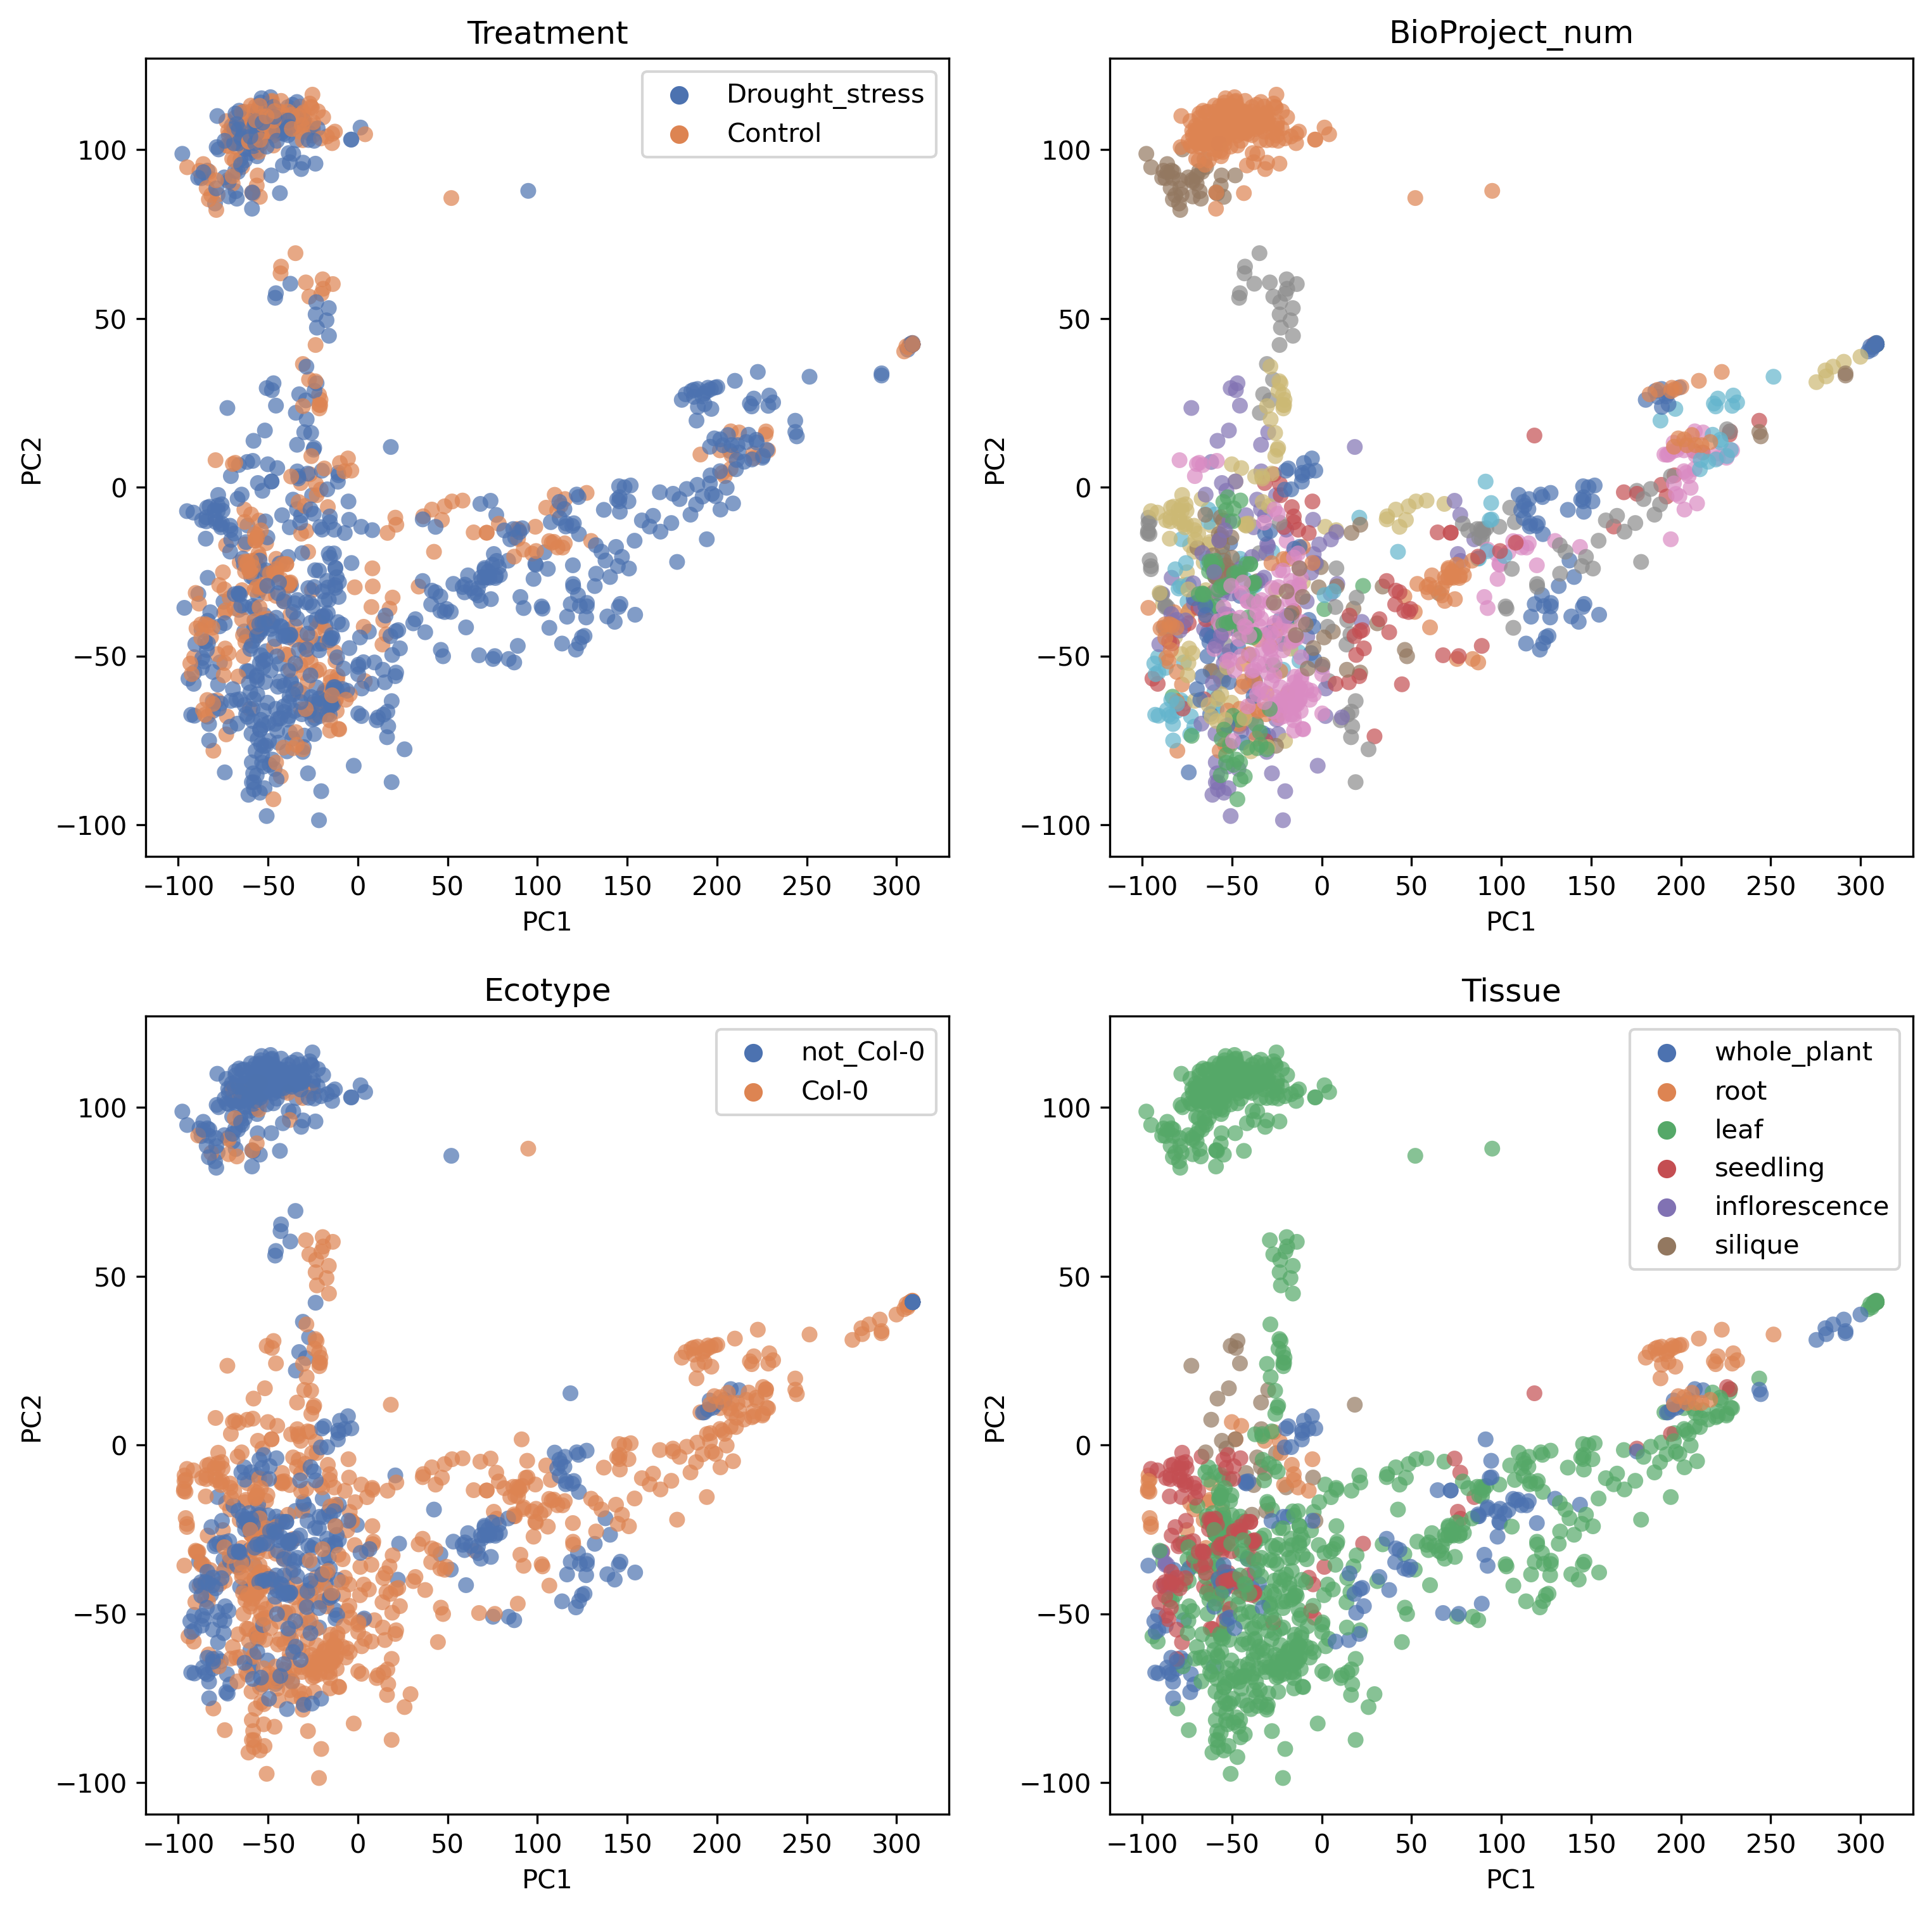

In [13]:
# Plot PCA by different factors

import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12, 12), dpi=300)
axs = axs.flatten()
def scatter_plot(df, x, y, ax, labels=None, title="", palette='deep'):
    sns.scatterplot(x=x, y=y, data=df,
                    ax=ax,
                    alpha=0.7, # opacity of the points
                    linewidth=0, # outline of the data points
                    hue=labels,
                    palette=palette)
    ax.set_title(title)
    
labels = label_df['Treatment'] 
labels2 = label_df['BioProject_num'] 
labels3 = label_df['Ecotype'] 
labels4 = label_df['Tissue'] 

scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[0], labels, "Treatment")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[1], labels2, "BioProject_num")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[2], labels3, "Ecotype")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[3], labels4, "Tissue")

# Set legend visibility
axs[0].legend().set_visible(True)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(True)
axs[3].legend().set_visible(True)

plt.savefig('Arabidopsis_drought_PCA_8-14.pdf')

### t-SNE

In [14]:
from sklearn.manifold import TSNE
import pandas as pd

def apply_tsne(data, num_c=2, perplexity=30, n_iter=1000):
    """
    data : data to fit t-SNE on
    num_c : Number of dimensions for t-SNE output
    perplexity : The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Typical values lie in the range 5-50.
    n_iter : Maximum number of iterations for the optimization. Should be at least 250.
    """
    tsne = TSNE(n_components=num_c, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(data)
    tsne_df = pd.DataFrame(data=tsne_results, columns=[f'Dim{i}' for i in range(1, num_c+1)])
    return tsne_df

In [16]:
# Return the % of variation that PC1 and PC2 explain in our data
tsne_df = apply_tsne(log_expr_df_trans)


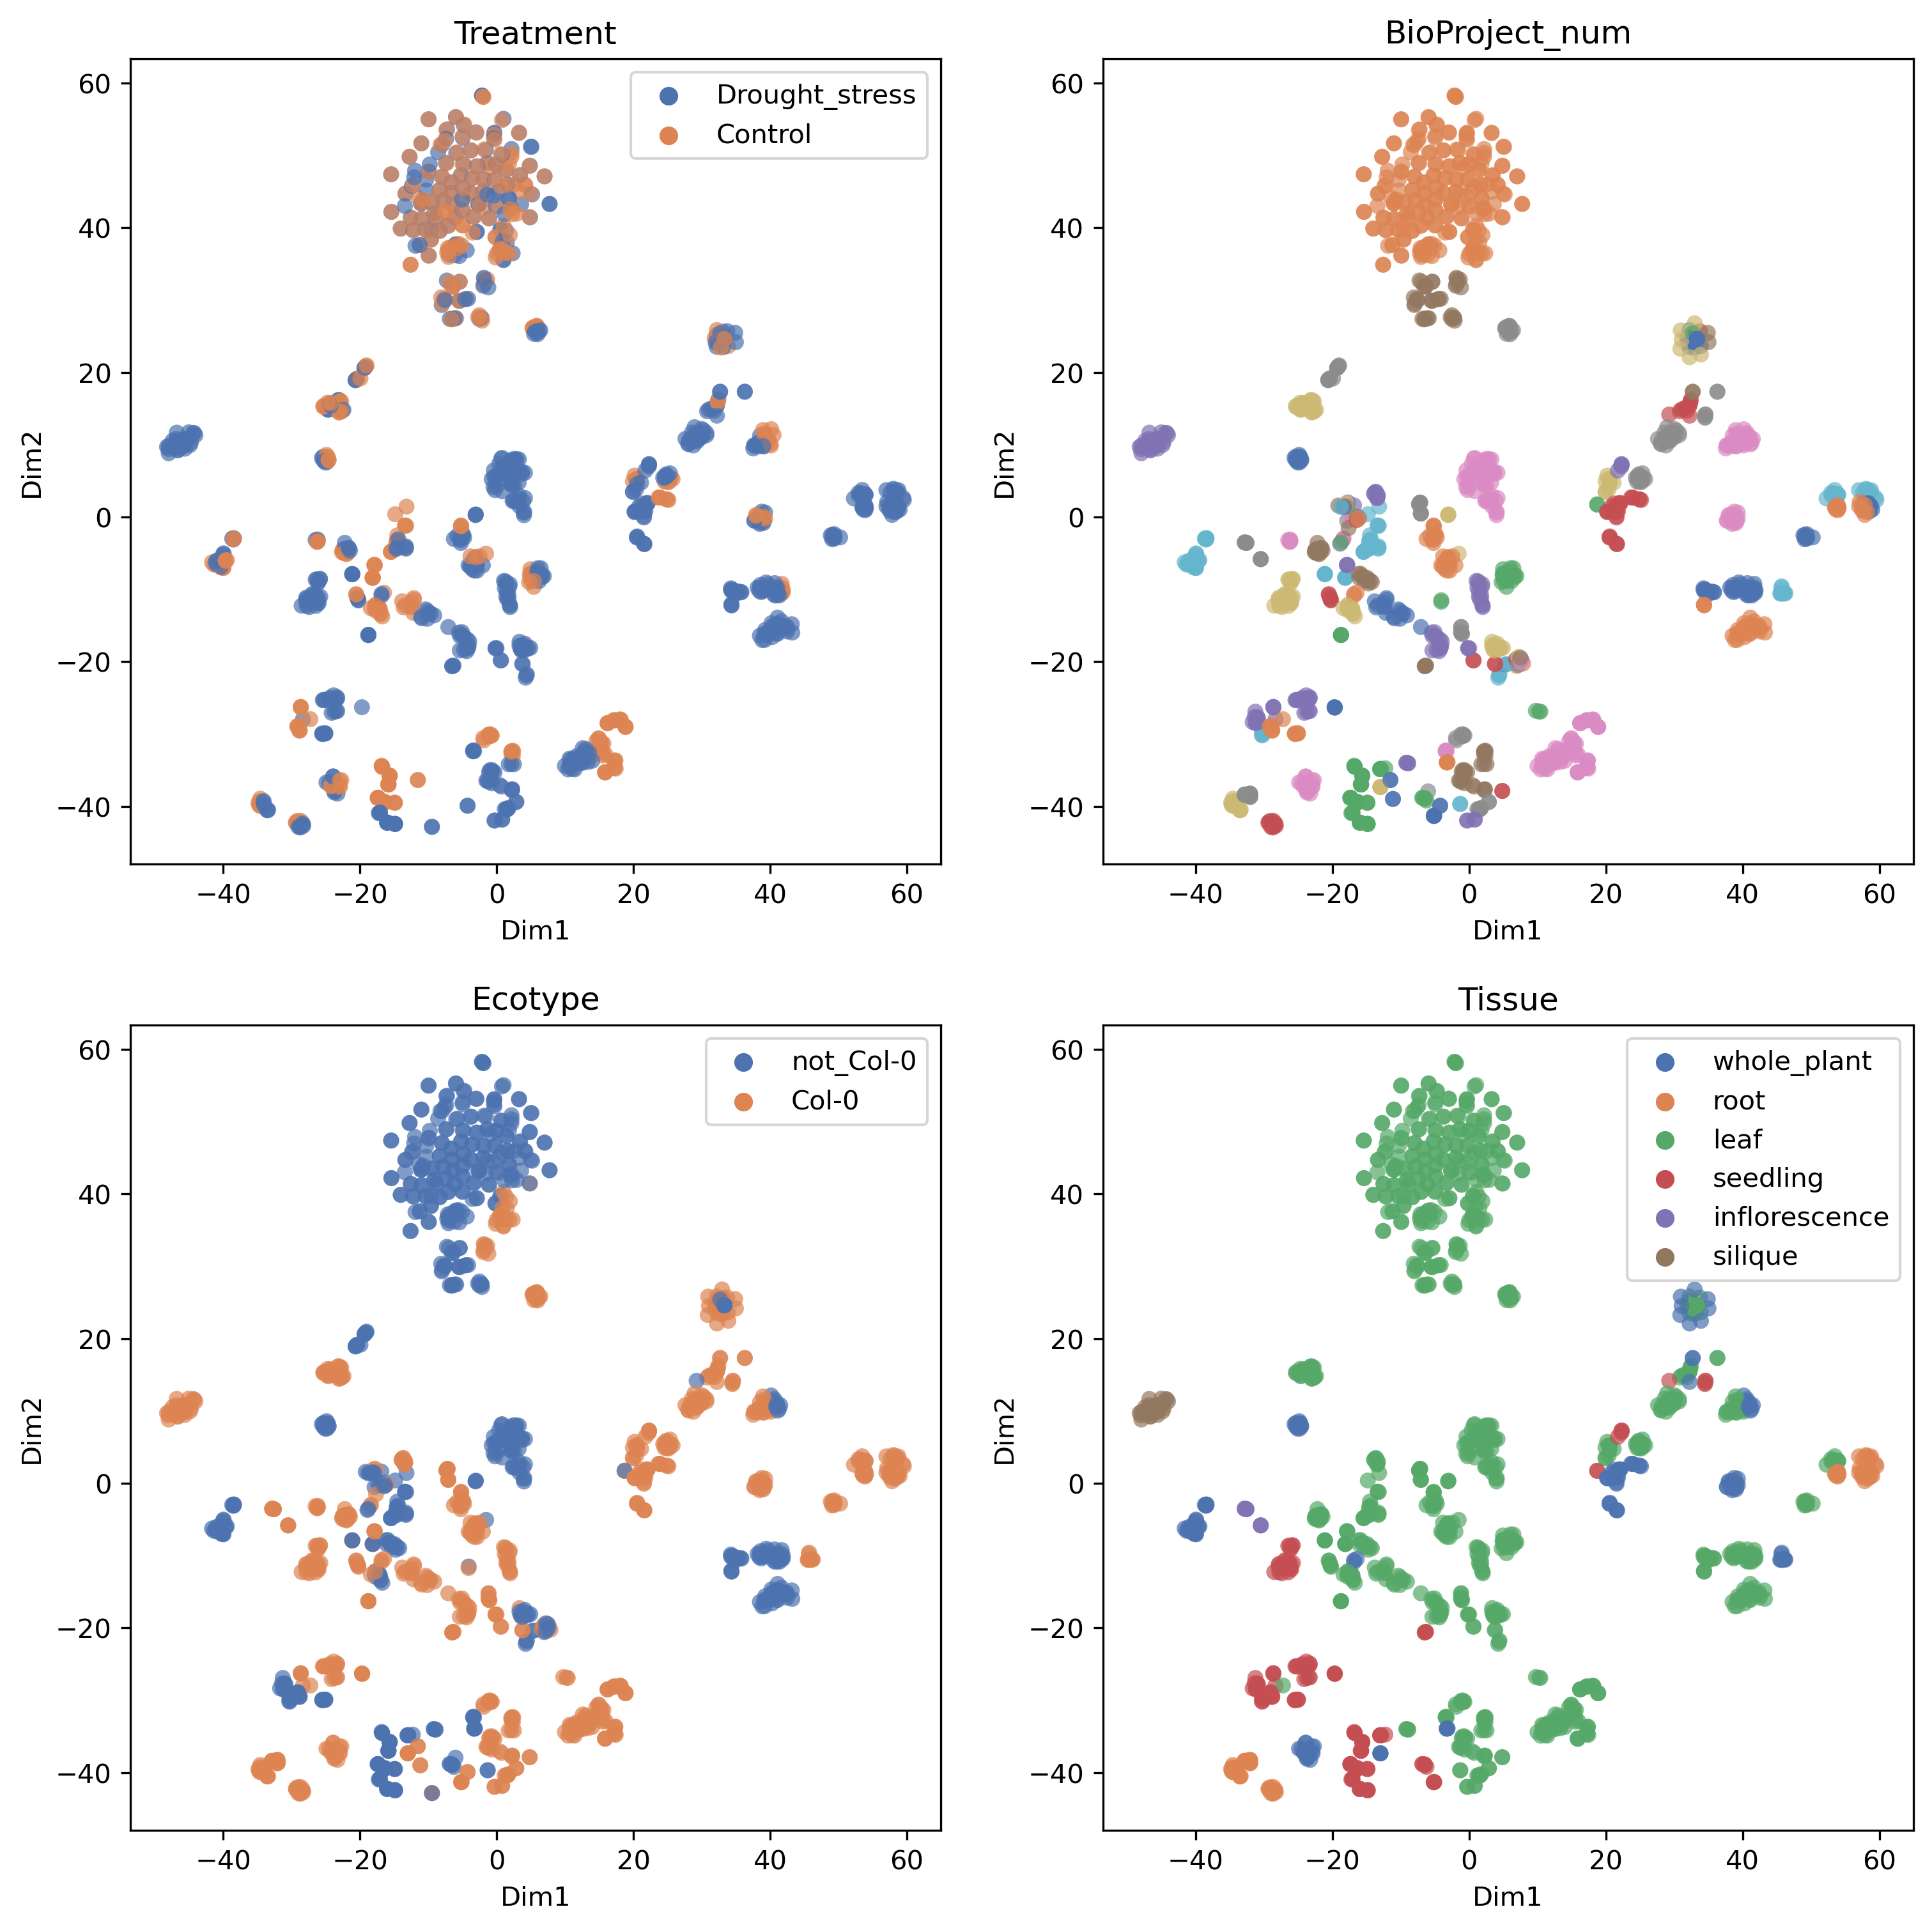

In [19]:
# Plot PCA by different factors

import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12, 12), dpi=300)
axs = axs.flatten()
def scatter_plot(df, x, y, ax, labels=None, title="", palette='deep'):
    sns.scatterplot(x=x, y=y, data=df,
                    ax=ax,
                    alpha=0.7, # opacity of the points
                    linewidth=0, # outline of the data points
                    hue=labels,
                    palette=palette)
    ax.set_title(title)
    
labels = label_df['Treatment'] 
labels2 = label_df['BioProject_num'] 
labels3 = label_df['Ecotype'] 
labels4 = label_df['Tissue'] 

scatter_plot(tsne_df, 'Dim1', 'Dim2', axs[0], labels, "Treatment")
scatter_plot(tsne_df, 'Dim1', 'Dim2', axs[1], labels2, "BioProject_num")
scatter_plot(tsne_df, 'Dim1', 'Dim2', axs[2], labels3, "Ecotype")
scatter_plot(tsne_df, 'Dim1', 'Dim2', axs[3], labels4, "Tissue")

# Set legend visibility
axs[0].legend().set_visible(True)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(True)
axs[3].legend().set_visible(True)

plt.savefig('Arabidopsis_drought_tsne_1-25.pdf')

## Using Combat to adjust for batch effects in the Arabiodpsis data

Bioproject was used as the factor for batch effect correction

In [23]:
from combat.pycombat import pycombat

In [24]:
filtered_df.head()

SRR13134698  SRR13134697  SRR13134696  SRR13134695  SRR13134694  \
GeneID                                                                       
AT1G01010     6.194397     6.755819     6.240131    11.211688    14.528159   
AT1G01020     6.313488     5.980893     6.799152    15.006115    13.306829   
AT1G01030     2.495984     2.453966     2.491543     3.122946     5.199754   
AT1G01040    15.888175    14.959274    13.426500    15.636013    15.652931   
AT1G01050    86.296448    76.257584    84.999951    92.253649    71.635072   

           SRR13134693  SRR13134692  SRR13134691  SRR13134690  SRR13134689  \
GeneID                                                                       
AT1G01010     3.364697    11.349768     6.977708     4.879251     3.677041   
AT1G01020     6.192358    15.266935     8.754127     4.351148     3.461339   
AT1G01030     3.316352     4.401286     2.549273     3.688480     3.267363   
AT1G01040     9.677851    16.475769    16.655656    10.282821     8.272203   
AT1G01050    75.300099    82.279578    83.941553    76.164501    85.124187   

           ...  SRR7217357  SRR7217358  SRR7217361  SRR7217362  SRR7217364  \
GeneID     ...                                                               
AT1G01010  ...    1.314620    0.980246    1.144093    0.224945    0.766847   
AT1G01020  ...    6.628328    8.727316    8.726632    2.895204    3.319839   
AT1G01030  ...    0.197505    0.104904    0.393433    0.160918    0.142264   
AT1G01040  ...    1.863715    1.312444    1.780143    0.860325    0.857214   
AT1G01050  ...   14.894059   12.494360   15.281672   12.017407   10.660425   

           SRR7217365  SRR7217367  SRR7217372  SRR7217373  SRR7217375  
GeneID                                                                 
AT1G01010    0.993218    0.688191    0.364360    0.618026    0.620158  
AT1G01020    5.118361    2.984822    1.740033    2.616836    2.756868  
AT1G01030    0.115867    0.124270    0.050160    0.034014    0.161809  
AT1G01040    1.262846    1.640237    1.041538    1.315620    1.218821  
AT1G01050   13.260913   18.150083    8.724780   11.025545    8.093256  

[5 rows x 1290 columns]

In [25]:
# Remove rows (genes) with constant expression across all columns (samples)
filtered_df = filtered_df[filtered_df.std(axis=1) != 0]

In [26]:
with open('Arabidopsis_combat_list.txt', 'r') as file:
    lines = file.readlines()

# Remove newline characters
lines = [line.strip() for line in lines]


In [27]:
df_corrected = pycombat(filtered_df, lines)

Found 66 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\15173\anaconda3\lib\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


Let's plot the PCA again and see if samples separate by stress level

In [28]:
#log transform the expression data

log_expr_df = log_transform(df_corrected)
log_expr_df.head()

C:\Users\15173\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


SRR13134698  SRR13134697  SRR13134696  SRR13134695  SRR13134694  \
GeneID                                                                       
AT1G01010     1.049202     1.200064     1.062379     1.947423     2.278010   
AT1G01020     2.937379     2.931284     2.946214     3.084791     3.057632   
AT1G01030     0.682670     0.665140     0.680831     0.913222     1.433240   
AT1G01040     2.086965     2.021647     1.903563     2.069651     2.070822   
AT1G01050     4.228095     4.068448     4.208855     4.312034     3.985387   

           SRR13134693  SRR13134692  SRR13134691  SRR13134690  SRR13134689  \
GeneID                                                                       
AT1G01010    -0.669695     1.963604     1.253932     0.568825    -0.260661   
AT1G01020     2.935164     3.088895     2.981009     2.900865     2.883858   
AT1G01030     0.974804     1.263758     0.704469     1.083581     0.959560   
AT1G01040     1.537506     2.126183     2.137888     1.606414     1.356281   
AT1G01050     4.051800     4.167239     4.192869     4.066842     4.210715   

           ...  SRR7217357  SRR7217358  SRR7217361  SRR7217362  SRR7217364  \
GeneID     ...                                                               
AT1G01010  ...    1.323323    1.278733    1.300831    1.170034    1.249200   
AT1G01020  ...    2.939197    2.992942    2.992925    2.835832    2.848143   
AT1G01030  ...    1.090698    1.070402    1.132330    1.082728    1.078640   
AT1G01040  ...    1.724648    1.702782    1.721364    1.684485    1.684357   
AT1G01050  ...    4.023369    4.013493    4.024955    4.011519    4.005880   

           SRR7217365  SRR7217367  SRR7217372  SRR7217373  SRR7217375  
GeneID                                                                 
AT1G01010    1.280501    1.238091    1.191007    1.228076    1.228382  
AT1G01020    2.898666    2.838443    2.801554    2.827679    2.831788  
AT1G01030    1.072826    1.074681    1.058207    1.054581    1.082923  
AT1G01040    1.700791    1.715841    1.691858    1.702909    1.699020  
AT1G01050    4.016659    4.036614    3.997781    4.007400    3.995124  

[5 rows x 1290 columns]

In [30]:
# Transpose the data so each row corresponds to an SRA numbers
expr_df_trans = expr_df.transpose()
log_expr_df_trans = log_expr_df.transpose()

log_expr_df_trans.head()


GeneID       AT1G01010  AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  \
SRR13134698   1.049202   2.937379   0.682670   2.086965   4.228095   3.124232   
SRR13134697   1.200064   2.931284   0.665140   2.021647   4.068448   3.151693   
SRR13134696   1.062379   2.946214   0.680831   1.903563   4.208855   3.028627   
SRR13134695   1.947423   3.084791   0.913222   2.069651   4.312034   2.991519   
SRR13134694   2.278010   3.057632   1.433240   2.070822   3.985387   2.974062   

GeneID       AT1G01070  AT1G01080  AT1G01090  AT1G01100  ...  ATMG01275  \
SRR13134698   1.918482   3.877963   4.333248   6.980901  ...   3.066776   
SRR13134697   1.009394   3.871046   4.291630   7.010648  ...   3.087721   
SRR13134696   0.892316   3.866316   4.219504   7.057567  ...   3.045780   
SRR13134695   1.977589   3.781654   4.147840   7.040035  ...   3.045780   
SRR13134694   0.955668   3.854769   4.149453   7.022109  ...   3.045780   

GeneID       ATMG01280  ATMG01290  ATMG01320  ATMG01330  ATMG01350  ATMG01360  \
SRR13134698   1.903433   0.281235   3.568388   2.277876   1.220677   4.280441   
SRR13134697   1.893066   0.281235   3.525822   2.040872   1.184958   4.271780   
SRR13134696   1.867946   0.478297   3.534647   2.000260   1.184958   4.268032   
SRR13134695   1.889807   0.281235   3.545476   2.018100   1.184958   4.270431   
SRR13134694   1.911315   0.281235   3.535235   2.258211   1.184958   4.269766   

GeneID       ATMG01370  ATMG01400  ATMG01410  
SRR13134698   2.291172   0.279952   0.281124  
SRR13134697   2.344855   0.279952   0.281124  
SRR13134696   2.358528   0.279952   0.281124  
SRR13134695   2.281433   0.279952   0.281124  
SRR13134694   2.280159   0.279952   0.281124  

[5 rows x 24591 columns]

In [32]:
log_expr_df_trans.fillna(0, inplace=True)

In [33]:
# Return the % of variation that PC1 and PC2 explain in our data
real_PCs_df = apply_pca(log_expr_df_trans)

log_real_PCs_df, log_pca = apply_pca(log_expr_df_trans, return_pca=True)
print(log_pca.explained_variance_ratio_)

[0.11890243 0.07172718]


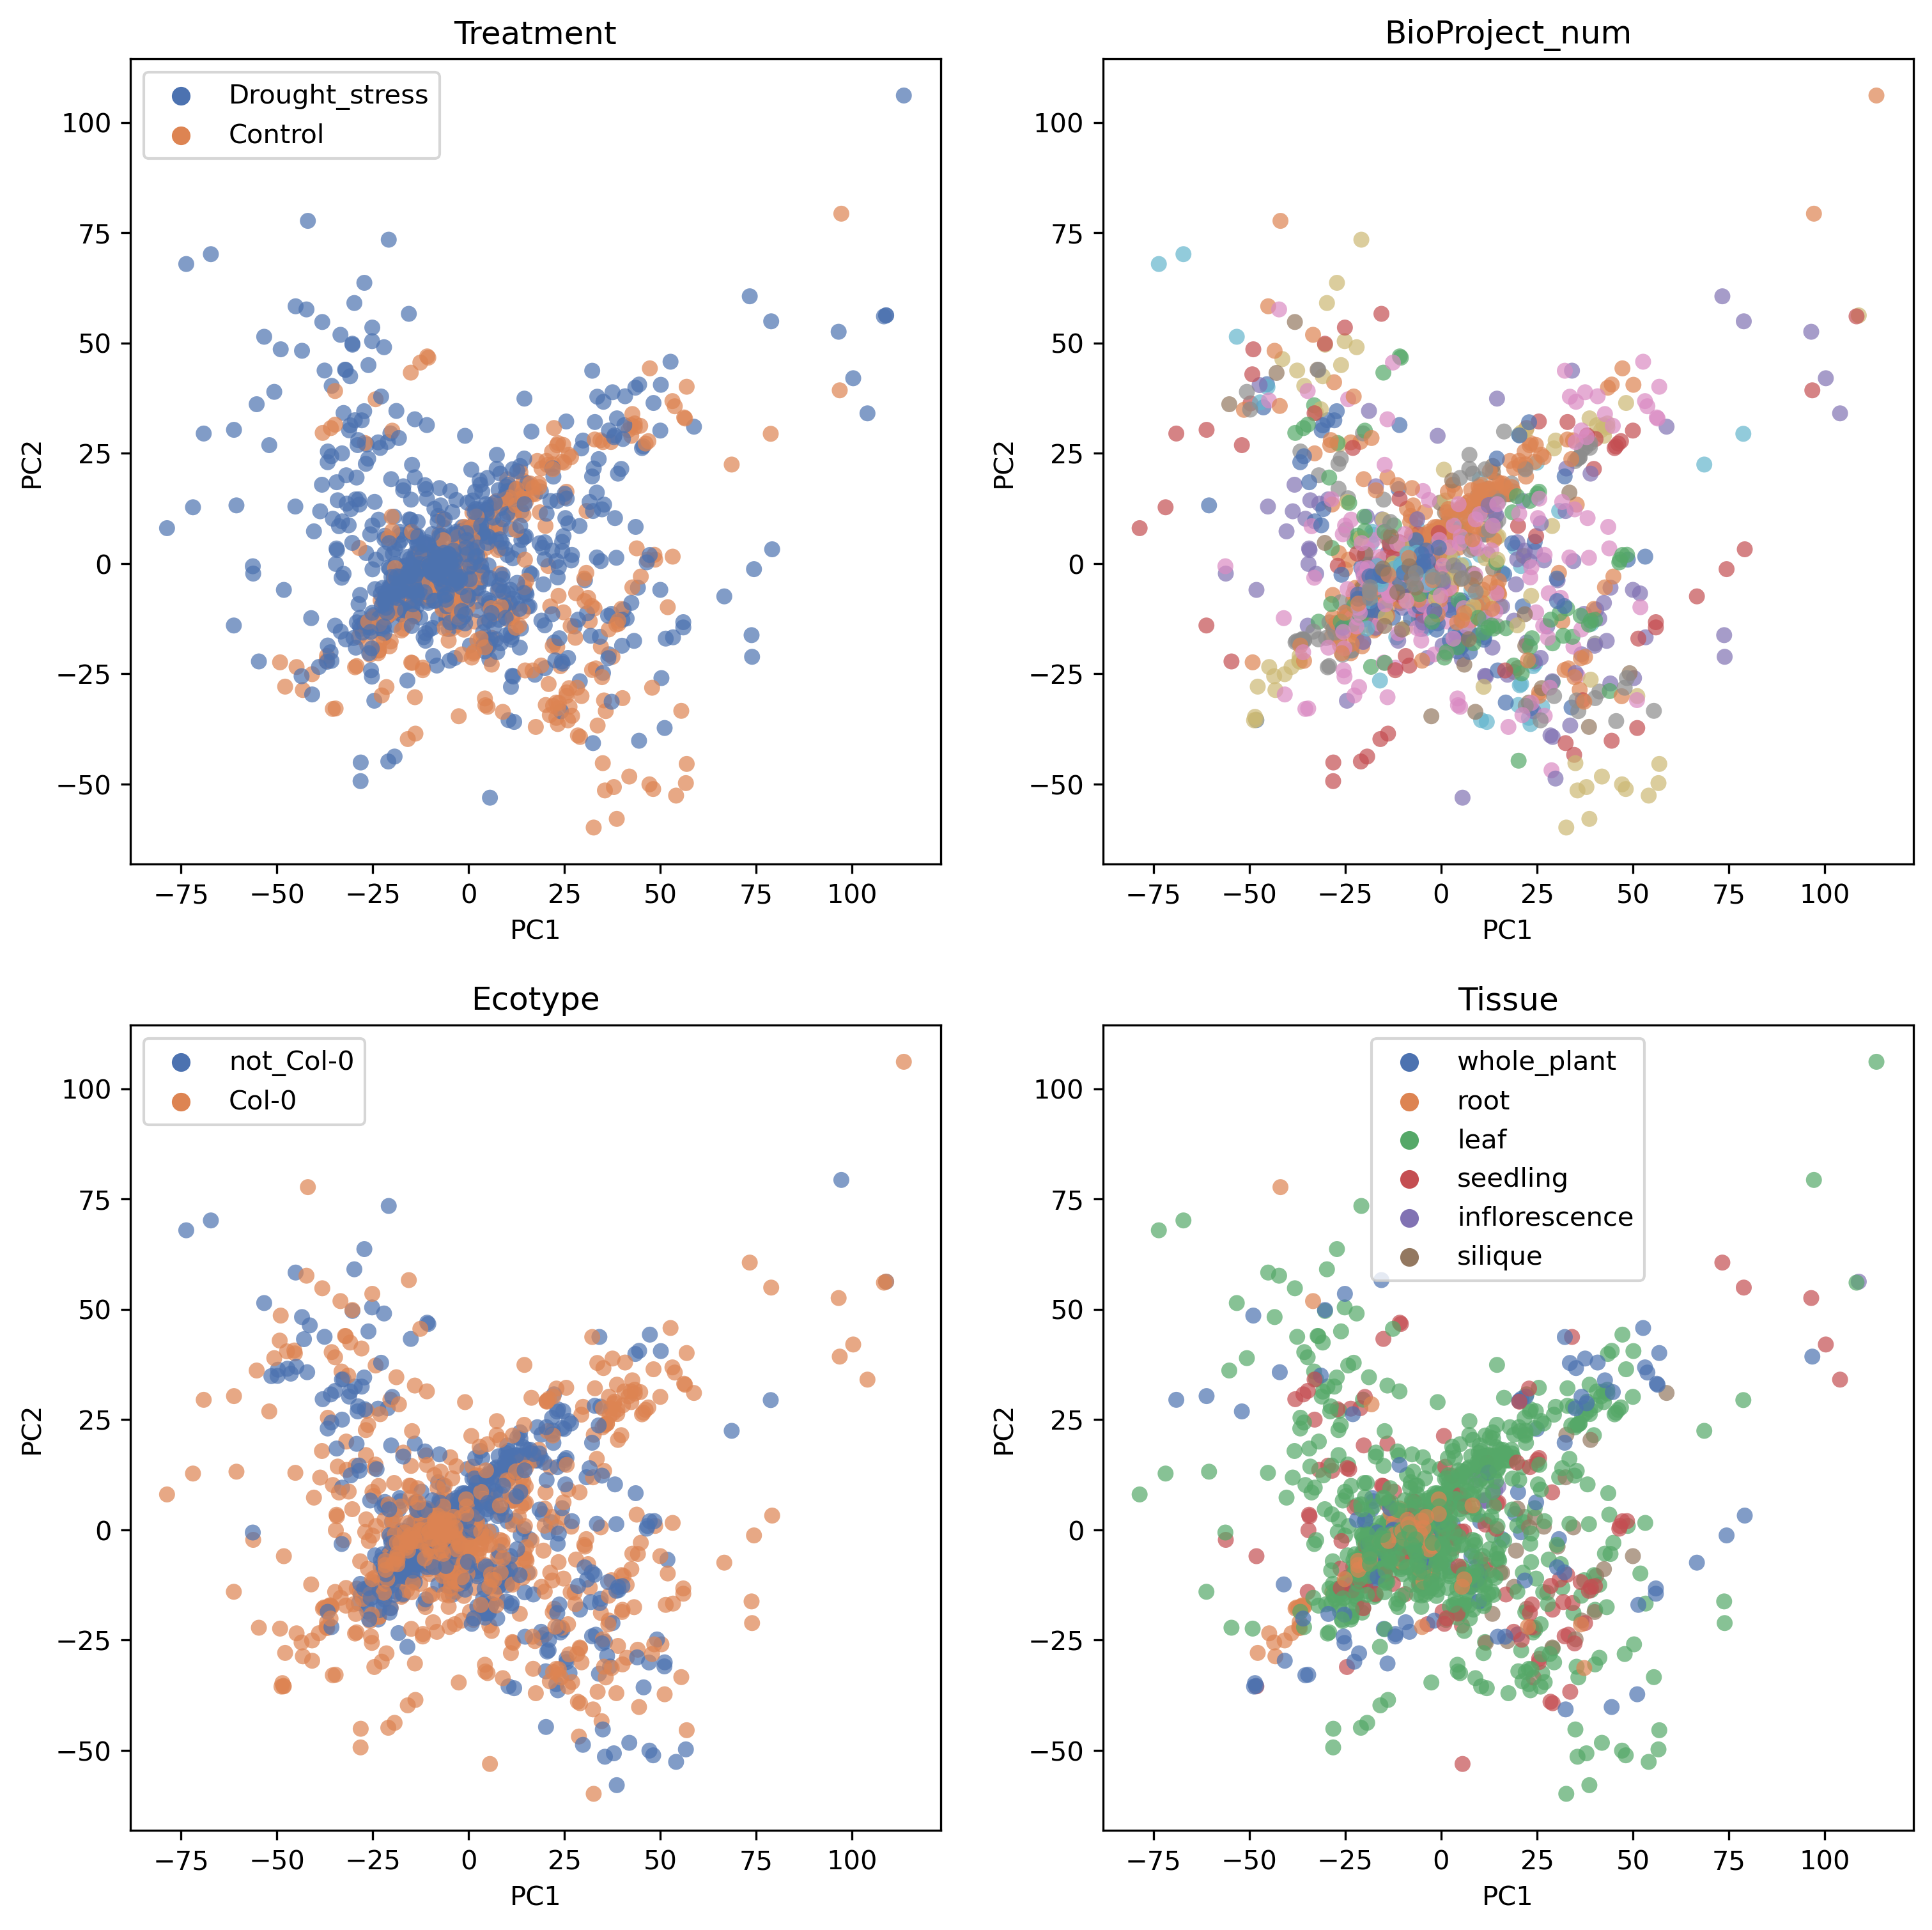

In [36]:
# Plot PCA by different factors

import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(12, 12), dpi=300)
axs = axs.flatten()
def scatter_plot(df, x, y, ax, labels=None, title="", palette='deep'):
    sns.scatterplot(x=x, y=y, data=df,
                    ax=ax,
                    alpha=0.7, # opacity of the points
                    linewidth=0, # outline of the data points
                    hue=labels,
                    palette=palette)
    ax.set_title(title)
    
labels = label_df['Treatment'] 
labels2 = label_df['BioProject_num'] 
labels3 = label_df['Ecotype'] 
labels4 = label_df['Tissue'] 

scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[0], labels, "Treatment")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[1], labels2, "BioProject_num")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[2], labels3, "Ecotype")
scatter_plot(real_PCs_df, 'PC1', 'PC2', axs[3], labels4, "Tissue")

# Set legend visibility
axs[0].legend().set_visible(True)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(True)
axs[3].legend().set_visible(True)

plt.savefig('Arabidopsis_drought_PCA_8-14_combat.pdf')

# Plotting expression of individual drought marker genes 
Now, let's plot the expression of individual drought marker genes. We will use the same log2+1 transformed expression matrix for Arabidopsis as above. 

In [20]:
log_expr_df_trans.head()

GeneID       AT1G01010  AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  \
SRR13134698   1.973303   1.989720   1.251615   2.826614   4.469310   2.534552   
SRR13134697   2.048443   1.943177   1.239523   2.770040   4.347145   2.626651   
SRR13134696   1.979639   2.054015   1.250344   2.669067   4.454347   2.154850   
SRR13134695   2.502394   2.772971   1.416568   2.811570   4.535323   1.971287   
SRR13134694   2.742655   2.660737   1.824510   2.812586   4.285448   1.874525   

GeneID       AT1G01070  AT1G01080  AT1G01090  AT1G01100  ...  ATMG01275  \
SRR13134698   2.442592   3.528407   4.589218   5.798741  ...   0.615206   
SRR13134697   1.969062   3.505378   4.534910   6.013694  ...   0.999145   
SRR13134696   1.922860   3.489413   4.439072   6.289056  ...   0.000000   
SRR13134695   2.480335   3.167088   4.341457   6.193354  ...   0.000000   
SRR13134694   1.947453   3.449664   4.343682   6.087006  ...   0.000000   

GeneID       ATMG01280  ATMG01290  ATMG01320  ATMG01330  ATMG01350  ATMG01360  \
SRR13134698   0.362489   0.000000   1.384015   1.735014   0.201441   1.335908   
SRR13134697   0.268239   0.000000   0.000000   0.472994   0.000000   0.935013   
SRR13134696   0.000000   0.387136   0.476009   0.000000   0.000000   0.696638   
SRR13134695   0.236895   0.000000   0.860832   0.233221   0.000000   0.855508   
SRR13134694   0.429225   0.000000   0.501084   1.666563   0.000000   0.813918   

GeneID       ATMG01370  ATMG01400  ATMG01410  
SRR13134698   0.456568        0.0        0.0  
SRR13134697   1.028488        0.0        0.0  
SRR13134696   1.137097        0.0        0.0  
SRR13134695   0.310835        0.0        0.0  
SRR13134694   0.290220        0.0        0.0  

[5 rows x 24591 columns]

In [21]:
raw_labels.head()

Instrument LibraryLayout  ReleaseDate  AvgSpotLen  \
Run                                                                     
SRR649737  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649738  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649739  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649740  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649741  Illumina_HiSeq_2000        SINGLE         2015       100.0   

            BioProject  BioProject_num    Ecotype       Treatment       Tissue  
Run                                                                             
SRR649737  PRJNA186735             1.0  not_Col-0         Control  whole_plant  
SRR649738  PRJNA186735             1.0  not_Col-0         Control  whole_plant  
SRR649739  PRJNA186735             1.0  not_Col-0  Drought_stress  whole_plant  
SRR649740  PRJNA186735             1.0  not_Col-0  Drought_stress  whole_plant  
SRR649741  PRJNA186735             1.0  not_Col-0         Control  whole_plant

In [22]:
# Make a merged dataframe
merged_df = raw_labels.join(log_expr_df_trans)
merged_df.head()

Instrument LibraryLayout  ReleaseDate  AvgSpotLen  \
Run                                                                     
SRR649737  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649738  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649739  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649740  Illumina_HiSeq_2000        SINGLE         2015       100.0   
SRR649741  Illumina_HiSeq_2000        SINGLE         2015       100.0   

            BioProject  BioProject_num    Ecotype       Treatment  \
Run                                                                 
SRR649737  PRJNA186735             1.0  not_Col-0         Control   
SRR649738  PRJNA186735             1.0  not_Col-0         Control   
SRR649739  PRJNA186735             1.0  not_Col-0  Drought_stress   
SRR649740  PRJNA186735             1.0  not_Col-0  Drought_stress   
SRR649741  PRJNA186735             1.0  not_Col-0         Control   

                Tissue  AT1G01010  ...  ATMG01275  ATMG01280  ATMG01290  \
Run                                ...                                    
SRR649737  whole_plant   0.605371  ...   0.000000   0.098089   0.000000   
SRR649738  whole_plant   0.647334  ...   0.147115   0.166753   0.000000   
SRR649739  whole_plant   0.710782  ...   0.000000   0.287461   0.239196   
SRR649740  whole_plant   0.577279  ...   0.496406   0.202127   0.227934   
SRR649741  whole_plant   0.656597  ...   0.155148   0.199710   0.000000   

           ATMG01320  ATMG01330  ATMG01350  ATMG01360  ATMG01370  ATMG01400  \
Run                                                                           
SRR649737   0.536242   1.732519   0.225790   0.712171   1.604123   0.131800   
SRR649738   0.801274   1.412338   0.642851   0.911424   1.799970   0.138117   
SRR649739   0.610988   1.435901   0.560044   0.813756   1.976193   0.000000   
SRR649740   0.727516   1.883561   0.416614   0.892052   2.643055   0.000000   
SRR649741   0.449411   1.493359   0.566640   0.914285   2.065212   0.000000   

           ATMG01410  
Run                   
SRR649737   0.081663  
SRR649738   0.082966  
SRR649739   0.000000  
SRR649740   0.000000  
SRR649741   0.000000  

[5 rows x 24600 columns]

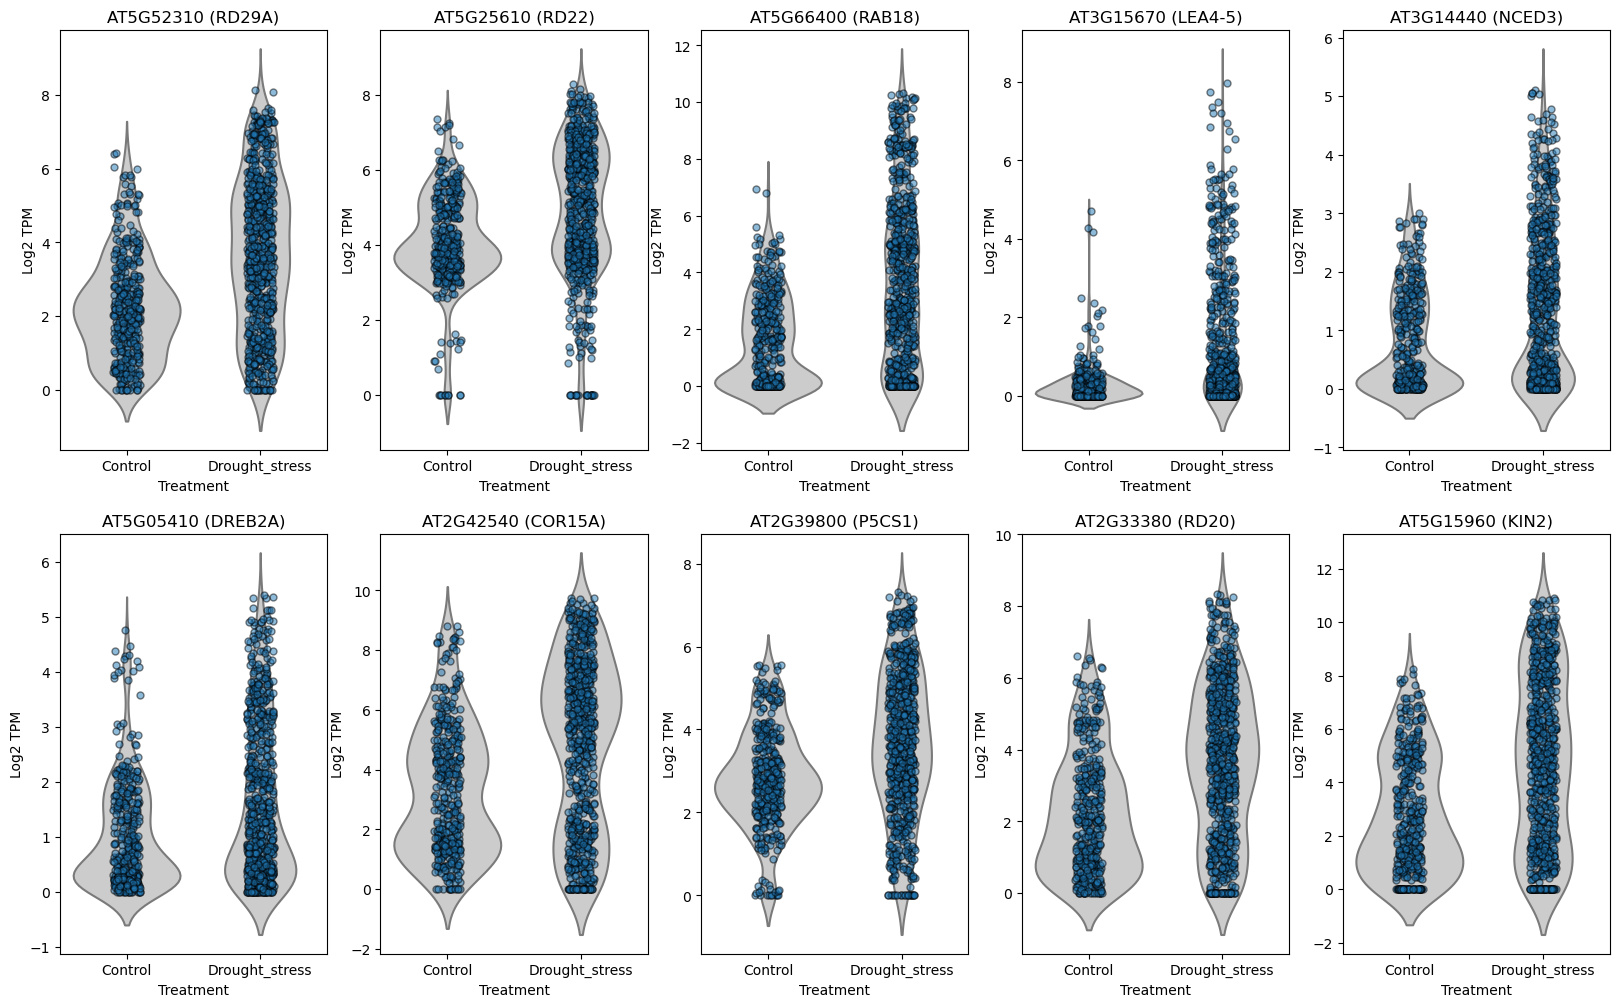

In [23]:
# Plotting a box plot on top of the violin plot

fig, axes = plt.subplots(2, 5, figsize=(20, 12))

sns.stripplot(x='Treatment', y='AT5G52310', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[0, 0])
sns.violinplot(x='Treatment', y='AT5G52310', data=merged_df, inner=None, color=".8", ax=axes[0, 0])

sns.stripplot(x='Treatment', y='AT5G25610', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[0, 1])
sns.violinplot(x='Treatment', y='AT5G25610', data=merged_df, inner=None, color=".8", ax=axes[0, 1])

sns.stripplot(x='Treatment', y='AT5G05410', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[1, 0])
sns.violinplot(x='Treatment', y='AT5G05410', data=merged_df, inner=None, color=".8", ax=axes[1, 0])

sns.stripplot(x='Treatment', y='AT2G42540', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[1, 1])
sns.violinplot(x='Treatment', y='AT2G42540', data=merged_df, inner=None, color=".8", ax=axes[1, 1])

sns.stripplot(x='Treatment', y='AT2G39800', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[1, 2])
sns.violinplot(x='Treatment', y='AT2G39800', data=merged_df, inner=None, color=".8", ax=axes[1, 2])

sns.stripplot(x='Treatment', y='AT2G33380', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[1, 3])
sns.violinplot(x='Treatment', y='AT2G33380', data=merged_df, inner=None, color=".8", ax=axes[1, 3])

sns.stripplot(x='Treatment', y='AT5G15960', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[1, 4])
sns.violinplot(x='Treatment', y='AT5G15960', data=merged_df, inner=None, color=".8", ax=axes[1, 4])

sns.stripplot(x='Treatment', y='AT5G66400', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[0, 2])
sns.violinplot(x='Treatment', y='AT5G66400', data=merged_df, inner=None, color=".8", ax=axes[0, 2])

sns.stripplot(x='Treatment', y='AT3G15670', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[0, 3])
sns.violinplot(x='Treatment', y='AT3G15670', data=merged_df, inner=None, color=".8", ax=axes[0, 3])

sns.stripplot(x='Treatment', y='AT3G14440', data=merged_df, edgecolor='black', linewidth=1, alpha=0.5, ax=axes[0, 4])
sns.violinplot(x='Treatment', y='AT3G14440', data=merged_df, inner=None, color=".8", ax=axes[0, 4])

axes[0, 0].set_title('AT5G52310 (RD29A)')
axes[0, 1].set_title('AT5G25610 (RD22)')
axes[1, 0].set_title('AT5G05410 (DREB2A)')
axes[1, 1].set_title('AT2G42540 (COR15A)')
axes[1, 2].set_title('AT2G39800 (P5CS1)')
axes[1, 3].set_title('AT2G33380 (RD20)')
axes[1, 4].set_title('AT5G15960 (KIN2)')
axes[0, 2].set_title('AT5G66400 (RAB18)')
axes[0, 3].set_title('AT3G15670 (LEA4-5)' )
axes[0, 4].set_title('AT3G14440 (NCED3)')

axes[0, 0].set_ylabel('Log2 TPM')
axes[0, 1].set_ylabel('Log2 TPM')
axes[1, 0].set_ylabel('Log2 TPM')
axes[1, 1].set_ylabel('Log2 TPM')
axes[1, 2].set_ylabel('Log2 TPM')
axes[1, 3].set_ylabel('Log2 TPM')
axes[1, 4].set_ylabel('Log2 TPM')
axes[0, 2].set_ylabel('Log2 TPM')
axes[0, 3].set_ylabel('Log2 TPM')
axes[0, 4].set_ylabel('Log2 TPM')

plt.savefig('Arabidopsis_drought_marker_violins_8_14_combat.pdf')
plt.show()

<Axes: xlabel='AT2G39800', ylabel='Count'>

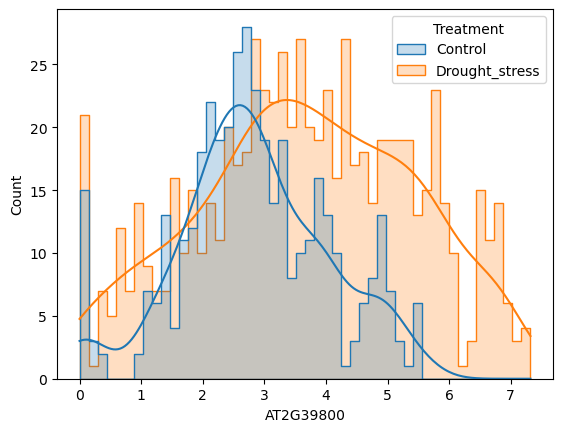

In [25]:
# Plotting historgram of an individual drought marker gene to look at the expression value distribution
sns.histplot(data=merged_df, x='AT2G39800', hue='Treatment', element='step', bins=50, kde=True)